# 타이타닉 생존자 예측 - Pro_6 (No Data Leakage + WCG)

## 🎯 Pro_6 핵심 전략
1. **Target Leakage 완전 방지**: sklearn Pipeline 내부에서 Preprocessor 적용
2. **KNN Imputer**: Age, Fare, Embarked 결측치 처리
3. **WCG 전략**: 가족 내 여성+아이 생존 → Master도 생존
4. **RepeatedStratifiedKFold**: n_repeats=10으로 안정적인 CV
5. **과적합 자동 조정**: check_overfitting_with_feedback 함수
6. **StandardScaler**: SVC, KNN, MLP, LogisticRegression에만 적용
7. **VIF 검증**: 다중공선성 피처 제거 후 검증

1. 탑다운 방식으로 먼저 수업때 배운 프롬프트 내용으로 노트북을 작성

2. 그 후 kaggle의 우수 사례를 바탕으로 어떻게 하면 score를 올릴수 있는지 확인

3. post-processing과 pseudo-labeling 으로 score를 억지로 높일수 있다는 것을 확인

4. 결정적으로 kaggle을 보고 실제 타이타닉 생존자 데이터를 가져와 매칭 시켜 1.00을 만들어봄.

5. 따라서, post-processing과 pseudo-labeling은 배제

6. 결측치 부분은 무작정 삭제하는 것 보다는 knn imputer나 다른 feature와의 관계로 채우는 방식을 채택

7. 가족 내에 여성과 아이가 생존 했다면 같은 가족인 남성도 생존 한다는 WCG 전략을 채택

8. 아이의 정의는 AgeBin 정의 후 10세 미만인 group 0으로 정함.

-> 여러번의 수정 중 다양한 데이터 전처리 전략 추가 및 수정 중 기존 코드가 사라지는 문제로 

꼬여서 전처리 상태가 꼬임. (낮은 score의 원인으로 추측)

9. 여러 구간 특히 optuna에서 과적합 발생 이를 확인하고 자체 피드백하는 함수 추가

10. CV에 RepeatedStratifiedKFold 사용

11. local에서 validation acc 가 과하게 높은데 kaggle submit acc는 굉장히 낮은 문제 발생

12. test.csv 데이터가 데이터 나누기 이전에 사용되어 data leak의 심각한 문제를 확인

13. pipeline 을 사용해 data leak 방지

14. local acc와 kaggle submit acc의 차이는 없애는 데에 성공. 그런데 낮은 score인 kaggle submit acc 로 통일. 0.8 이하

15. 반복 수정을 하면서 kaggle의 코드를 붙이다 보니 의미없이 비슷한 의미의 feature가 많아진것을 EDA에서 확인

16.  VIF analysis를 도입해 필요없는 feature 제거

17. 이후에 직접 확인해 gemini의 도움으로 필요없는 feature 타겟 제거

18. 많은 반복으로 agent의 도움으로 수정을 하다보니 기존에 추가했던 핵심 기능 들이 요청 없이 멋대로 사라지는 현상을 확인. 
-> 이 문제로 인해 어떤 부분이 적용되고 사라졌는지 파악하기 어려워 스스로도 헷갈리게 됨. 전부 읽고 파악해도 수정 한번 하면 또 사라짐. 통째 수정은 앞으로는 자제 할것.
-> 후반부에는 .py파일로 따로 만들어 셀별 수정 파트 확인 후 스스로 overwrite하는 방식으로 바꿈.
(planning으로 주로 Gemini 3 pro (High), Claude Opus 4.5 (Thinking) 사용)

19. 최소 14시간 이상 작업 했지만 0.8 이상 개선 불가. 해석 모델 보다도 전처리 과정이 중요한 것을 확실히 깨달음. 일일 submit 제한이 걸려 작업 마무리. 토요일은 일정이 있어 작업 불가능.


In [122]:
# ============================================================
# 1. 라이브러리 임포트
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import platform

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV  # NEW: RFECV for systematic feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # NEW: Add SVC for model diversity
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

# VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Visualization settings
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# ------------------------------------------------------------
# Korean Font Settings
# ------------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    print('🪟 Windows: Malgun Gothic 설정')
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin': 
    print('🍎 Mac: AppleGothic 설정')
    plt.rc('font', family='AppleGothic')
elif 'google.colab' in sys.modules:
    print('☁️ Colab: NanumBarunGothic 설치 및 설정')
    !apt-get update -qq
    !apt-get install fonts-nanum* -qq
    import matplotlib.font_manager as fm
    fe = fm.FontEntry(
        fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
        name='NanumBarunGothic')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rc('font', family=fe.name)
else:
    # Linux / Kaggle / Other
    print('🐧 Linux/Other: NanumGothic 설정')
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

print('✅ 라이브러리 임포트 및 한글 폰트 설정 완료')


🪟 Windows: Malgun Gothic 설정
✅ 라이브러리 임포트 및 한글 폰트 설정 완료


In [123]:
# ============================================================
# 2. 데이터 불러오기
# ============================================================
base_path = r'C:/Users/user/github/DataScience/scikit-learn/scikit-learn/data/titanic'
train_df = pd.read_csv(f'{base_path}/train.csv')
test_df = pd.read_csv(f'{base_path}/test.csv')

test_passenger_ids = test_df['PassengerId'].copy()
train_len = len(train_df)
all_data = pd.concat([train_df, test_df], ignore_index=True)

print(f'Train: {train_df.shape}, Test: {test_df.shape}, All: {all_data.shape}')

Train: (891, 12), Test: (418, 11), All: (1309, 12)


In [124]:
# ============================================================
# 3. KNN Imputer for Age, Fare, Embarked
# ============================================================

def find_best_k_neighbors(train_df):
    print('🔍 KNN Imputer n_neighbors 최적화 중...')
    results = []
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    
    for k in range(3, 12, 2):
        df = train_df.copy()
        df['Sex_num'] = (df['Sex'] == 'male').astype(int)
        df['Embarked_num'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).fillna(-1)
        
        imputer_cols = ['Pclass', 'Sex_num', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']
        imputer = KNNImputer(n_neighbors=k)
        df_imputed = pd.DataFrame(imputer.fit_transform(df[imputer_cols]), columns=imputer_cols)
        df['Age'] = df_imputed['Age']
        df['Fare'] = df_imputed['Fare']
        df['Embarked_num'] = df_imputed['Embarked_num'].round().astype(int)
        
        X = df[['Pclass', 'Sex_num', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']]
        y = df['Survived'].astype(int)
        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        results.append({'k': k, 'cv_accuracy': scores.mean()})
        print(f'  k={k}: CV Accuracy = {scores.mean():.4f}')
    
    results_df = pd.DataFrame(results)
    best_k = results_df.loc[results_df['cv_accuracy'].idxmax(), 'k']
    print(f'\n🏆 최적 n_neighbors = {best_k}')
    return int(best_k)

best_k = find_best_k_neighbors(train_df)

🔍 KNN Imputer n_neighbors 최적화 중...
  k=3: CV Accuracy = 0.8202
  k=5: CV Accuracy = 0.8211
  k=7: CV Accuracy = 0.8242
  k=9: CV Accuracy = 0.8215
  k=11: CV Accuracy = 0.8202

🏆 최적 n_neighbors = 7


In [125]:
# ============================================================
# 4. WCG (Women, Children, Group) 전략 + KNN Imputer 적용
# ============================================================

def add_wcg_family_survival(all_data, train_len, best_k):
    all_data = all_data.copy()
    
    # Basic features
    all_data['Last_Name'] = all_data['Name'].apply(lambda x: x.split(',')[0])
    all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    all_data['TicketFrequency'] = all_data['Ticket'].map(all_data['Ticket'].value_counts())
    all_data['Sex_num'] = (all_data['Sex'] == 'male').astype(int)
    all_data['Embarked_num'] = all_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # KNN Imputer for Age, Fare, Embarked
    print(f'🔧 KNN Imputer 적용 (n_neighbors={best_k})...')
    imputer_cols = ['Pclass', 'Sex_num', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_num']
    imputer = KNNImputer(n_neighbors=best_k)
    df_imputed = pd.DataFrame(imputer.fit_transform(all_data[imputer_cols]), columns=imputer_cols, index=all_data.index)
    all_data['Age'] = df_imputed['Age']
    all_data['Fare'] = df_imputed['Fare']
    all_data['Embarked_num'] = df_imputed['Embarked_num'].round().astype(int)
    
    # Fare per person
    all_data['Fare_Per_Person'] = all_data['Fare'] / all_data['TicketFrequency']
    all_data['Fare_Per_Person_Round'] = all_data['Fare_Per_Person'].round(2)
    
    # Gender/Age flags
    all_data['IsChild'] = (all_data['Age'] < 10).astype(int)
    all_data['IsFemale'] = (all_data['Sex'] == 'female').astype(int)
    all_data['IsMaster'] = (all_data['Title'] == 'Master').astype(int)
    all_data['IsMaleChild'] = ((all_data['Sex'] == 'male') & (all_data['IsChild'] == 1)).astype(int)
    
    # Family Survival
    all_data['Family_Survival'] = 0.5
    all_data['WCG_Survival'] = 0
    
    print('📊 Family_Survival 계산 중...')
    for ticket, grp_df in all_data.groupby('Ticket'):
        if len(grp_df) > 1:
            for idx in grp_df.index:
                others = grp_df.drop(idx)
                others_train = others[others.index < train_len]
                if len(others_train) > 0:
                    if others_train['Survived'].max() == 1.0:
                        all_data.loc[idx, 'Family_Survival'] = 1
                    elif others_train['Survived'].min() == 0.0:
                        all_data.loc[idx, 'Family_Survival'] = 0
    
    for (last_name, fare_pp, embarked), grp_df in all_data.groupby(['Last_Name', 'Fare_Per_Person_Round', 'Embarked_num']):
        if len(grp_df) > 1:
            for idx in grp_df.index:
                if all_data.loc[idx, 'Family_Survival'] == 0.5:
                    others = grp_df.drop(idx)
                    others_train = others[others.index < train_len]
                    if len(others_train) > 0:
                        if others_train['Survived'].max() == 1.0:
                            all_data.loc[idx, 'Family_Survival'] = 1
                        elif others_train['Survived'].min() == 0.0:
                            all_data.loc[idx, 'Family_Survival'] = 0
    
    print('🎯 WCG 전략 적용 중...')
    for ticket, grp_df in all_data.groupby('Ticket'):
        if len(grp_df) > 1:
            grp_train = grp_df[grp_df.index < train_len]
            if len(grp_train) > 0:
                women_children = grp_train[(grp_train['IsFemale'] == 1) | (grp_train['IsChild'] == 1)]
                if len(women_children) > 0 and (women_children['Survived'] == 1).all():
                    for idx in grp_df.index:
                        if all_data.loc[idx, 'IsMaster'] == 1 or all_data.loc[idx, 'IsMaleChild'] == 1:
                            all_data.loc[idx, 'WCG_Survival'] = 1
                            all_data.loc[idx, 'Family_Survival'] = 1
    
    print(f'✅ Family_Survival 분포: {all_data["Family_Survival"].value_counts().to_dict()}')
    return all_data

all_data = add_wcg_family_survival(all_data, train_len, best_k)
print('\n✅ KNN Imputer + WCG 특성 생성 완료')

🔧 KNN Imputer 적용 (n_neighbors=7)...
📊 Family_Survival 계산 중...
🎯 WCG 전략 적용 중...
✅ Family_Survival 분포: {0.5: 754, 1.0: 309, 0.0: 246}

✅ KNN Imputer + WCG 특성 생성 완료


In [126]:
# ============================================================
# 5. Feature Engineering (with Expanded Binning)
# ============================================================

def preprocessing_pro5(all_data):
    all_data = all_data.copy()
    
    title_mapping = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare', 'Capt': 'Rare',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Rare', 'Countess': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Jonkheer': 'Rare'}
    all_data['Title'] = all_data['Title'].map(title_mapping).fillna('Rare')
    all_data['Sex'] = (all_data['Sex'] == 'male').astype(int)
    all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
    all_data['IsAlone'] = (all_data['FamilySize'] == 1).astype(int)
    
    # AgeBin
    def age_to_bin(age):
        if pd.isna(age): return 2
        elif age < 10: return 0
        elif age < 18: return 1
        elif age < 35: return 2
        elif age < 50: return 3
        else: return 4
    all_data['AgeBin'] = all_data['Age'].apply(age_to_bin).astype(int)
    
    # FareBin (NEW)
    def fare_to_bin(fare):
        if pd.isna(fare) or fare <= 7.91: return 0
        elif fare <= 14.45: return 1
        elif fare <= 31.0: return 2
        elif fare <= 100.0: return 3
        else: return 4
    all_data['FareBin'] = all_data['Fare_Per_Person'].apply(fare_to_bin).astype(int)
    
    # FamilySizeBin (NEW)
    def familysize_to_bin(size):
        if size == 1: return 0
        elif size <= 3: return 1
        elif size <= 5: return 2
        else: return 3
    all_data['FamilySizeBin'] = all_data['FamilySize'].apply(familysize_to_bin).astype(int)
    
    all_data['LogFare'] = np.log1p(all_data['Fare_Per_Person'])
    all_data['Deck'] = all_data['Cabin'].str[0].fillna('U')
    deck_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 0, 'U': 0}
    all_data['Deck'] = all_data['Deck'].map(deck_map).fillna(0).astype(int)
    title_enc = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
    all_data['Title'] = all_data['Title'].map(title_enc).fillna(4).astype(int)
    all_data['Sex_Pclass'] = all_data['Sex'] * all_data['Pclass']
    
    return all_data

all_data = preprocessing_pro5(all_data)
print('✅ Feature Engineering 완료 (FareBin, FamilySizeBin 추가)')


✅ Feature Engineering 완료 (FareBin, FamilySizeBin 추가)


In [127]:
# ============================================================
# 5.5 VIF Analysis (Reference Only - No Data Leak)
# ============================================================

# Fixed feature list (no dynamic selection to avoid leak)
features = ['Pclass', 'Sex', 'LogFare', 'Embarked_num', 'Title', 
            'Family_Survival', 'TicketFrequency', 'Deck', 'AgeBin', 
            'FareBin', 'FamilySizeBin']
# Note: Sex_Pclass removed due to high VIF with Sex

train_processed = all_data.iloc[:train_len].copy()
test_processed = all_data.iloc[train_len:].copy()

# VIF Analysis for REFERENCE ONLY
print('📊 VIF Analysis (Reference Only):')
print('=' * 50)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

X_temp = train_processed[features]
vif_df = calculate_vif(X_temp)
print(vif_df.to_string(index=False))
print(f'\\n✅ Using fixed feature list ({len(features)} features) - no leak from VIF')

📊 VIF Analysis (Reference Only):
        Feature       VIF
        LogFare 44.788243
         Pclass 15.093113
        FareBin 12.471814
         AgeBin  7.905106
TicketFrequency  5.384426
Family_Survival  4.012949
  FamilySizeBin  3.881358
            Sex  3.728619
          Title  2.188763
           Deck  1.843737
   Embarked_num  1.426716
\n✅ Using fixed feature list (11 features) - no leak from VIF


In [128]:
# ============================================================
# 6. 데이터 분리 (No Data Leak)
# ============================================================

# Use fixed features (no RFECV to avoid leak)
X = train_processed[features]
y = train_processed['Survived'].astype(int)
X_test = test_processed[features]

# CV settings
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_optuna = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# NOTE: No scaler.fit_transform() here! 
# Scaler will be inside Pipeline to prevent leak

print(f'Train: {X.shape}, Test: {X_test.shape}')
print(f'Features ({len(features)}): {features}')
print(f'✅ No StandardScaler leak - will use Pipeline')

Train: (891, 11), Test: (418, 11)
Features (11): ['Pclass', 'Sex', 'LogFare', 'Embarked_num', 'Title', 'Family_Survival', 'TicketFrequency', 'Deck', 'AgeBin', 'FareBin', 'FamilySizeBin']
✅ No StandardScaler leak - will use Pipeline


# 7. 탐색적 데이터 분석 (EDA)

생존에 영향을 미치는 주요 요인들을 시각화합니다.

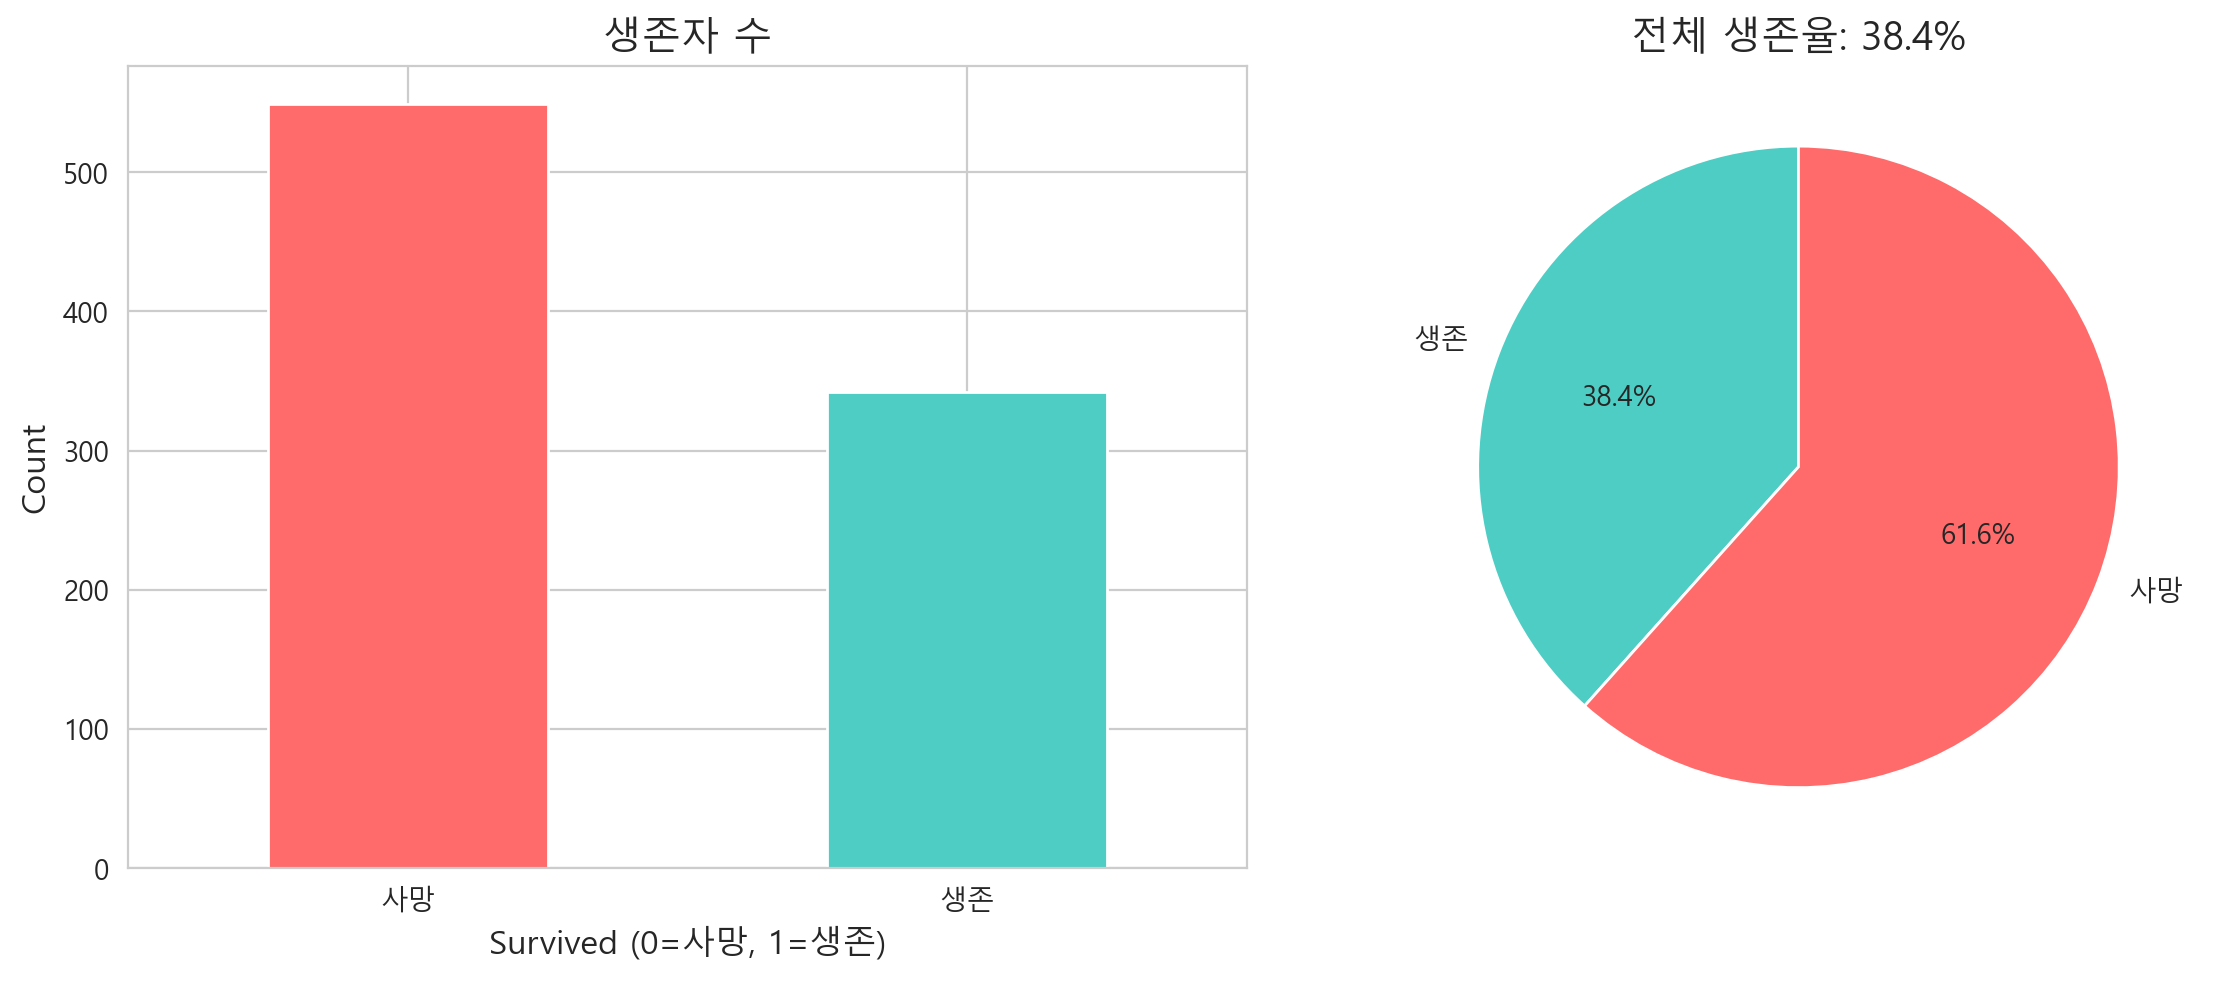

In [129]:
# ============================================================
# 7-1. 전체 생존율
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train_processed['Survived'].value_counts().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('생존자 수', fontsize=14)
axes[0].set_xlabel('Survived (0=사망, 1=생존)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['사망', '생존'], rotation=0)

survival_rate = train_processed['Survived'].mean() * 100
axes[1].pie([survival_rate, 100-survival_rate], labels=['생존', '사망'], 
            autopct='%1.1f%%', colors=['#4ecdc4', '#ff6b6b'], startangle=90)
axes[1].set_title(f'전체 생존율: {survival_rate:.1f}%', fontsize=14)
plt.tight_layout()
plt.show()

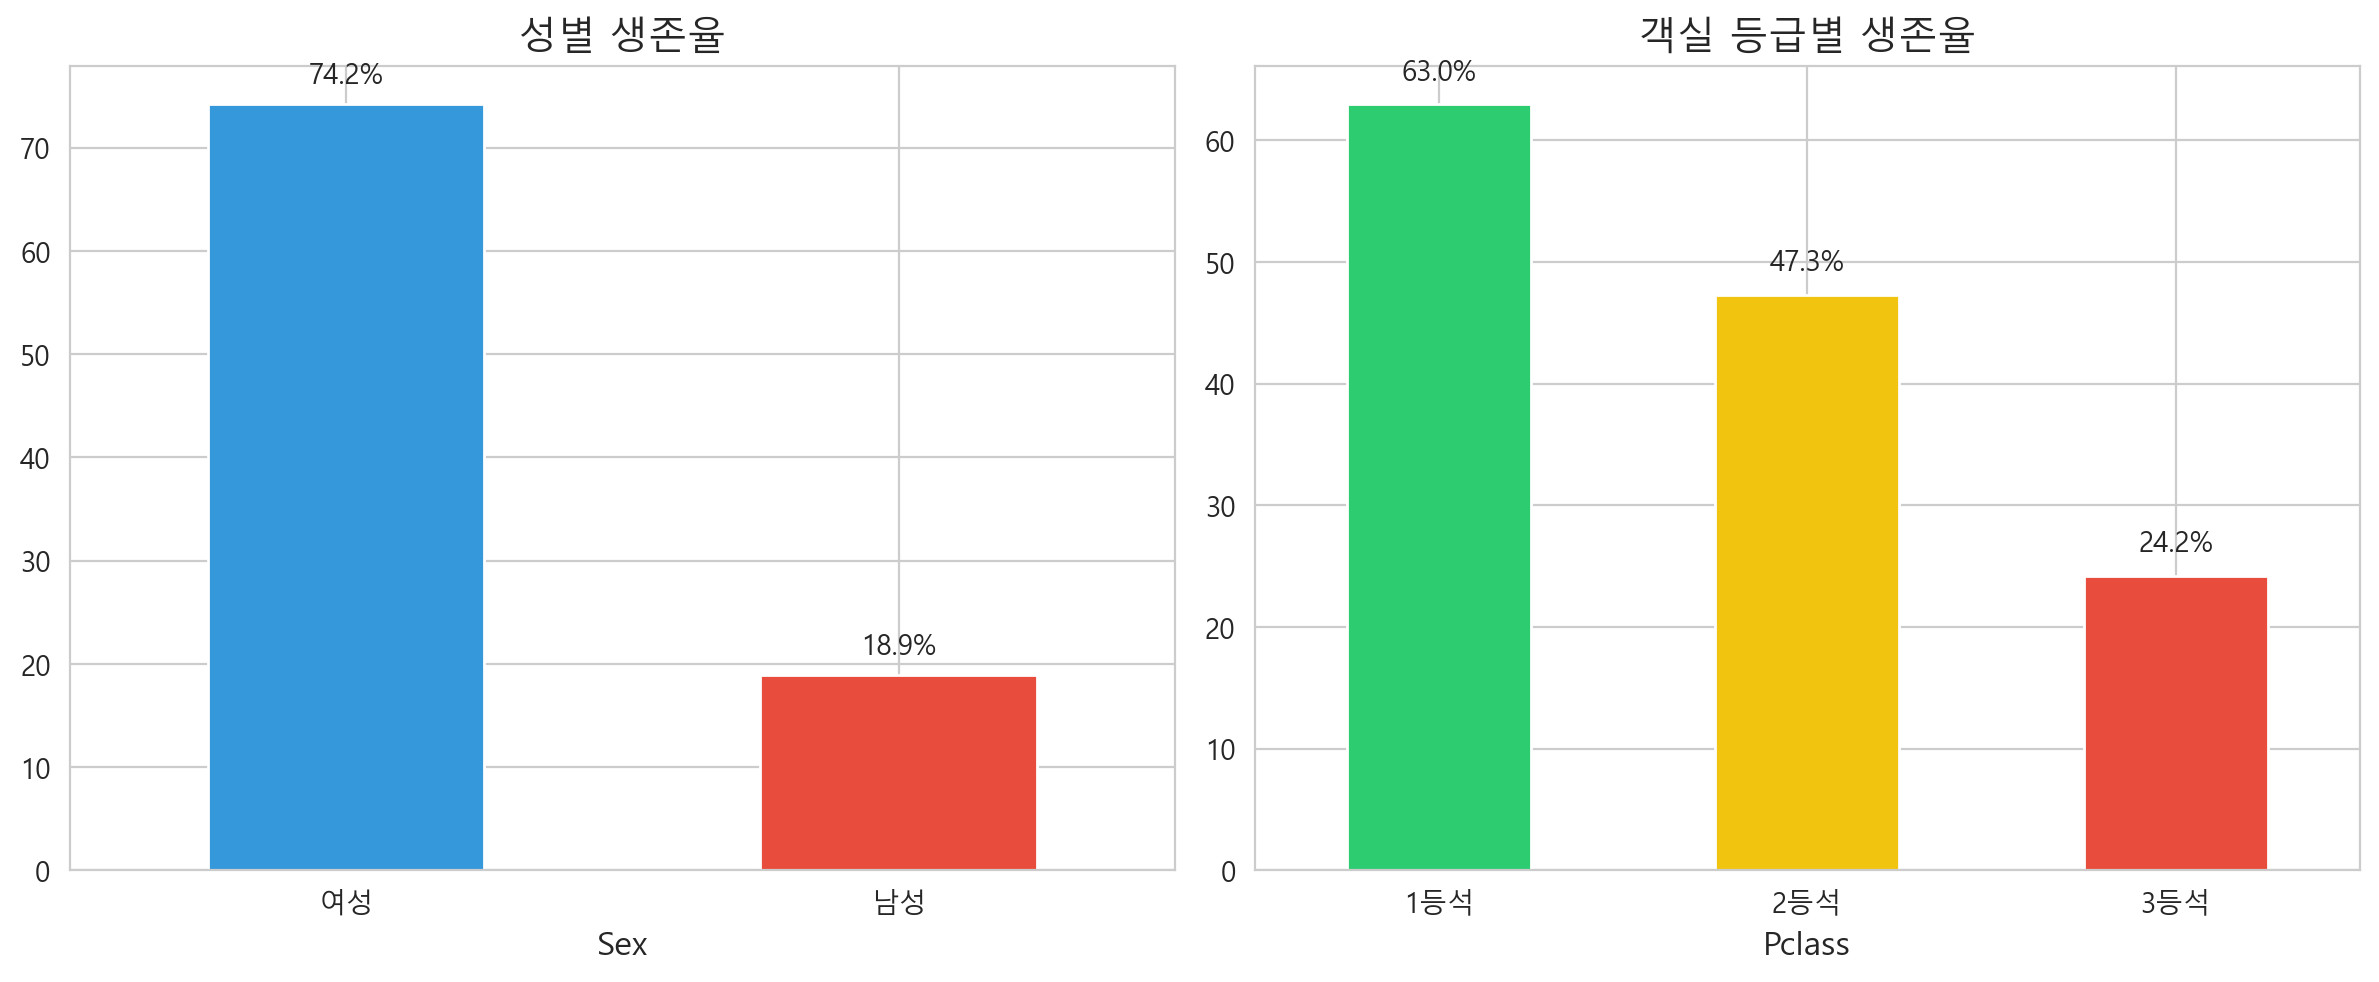

In [130]:
# ============================================================
# 7-2. 성별/등급별 생존율
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sex_survival = train_processed.groupby('Sex')['Survived'].mean() * 100
sex_survival.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('성별 생존율', fontsize=14)
axes[0].set_xticklabels(['여성', '남성'], rotation=0)
for i, v in enumerate(sex_survival): axes[0].text(i, v + 2, f'{v:.1f}%', ha='center')

pclass_survival = train_processed.groupby('Pclass')['Survived'].mean() * 100
pclass_survival.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#f1c40f', '#e74c3c'])
axes[1].set_title('객실 등급별 생존율', fontsize=14)
axes[1].set_xticklabels(['1등석', '2등석', '3등석'], rotation=0)
for i, v in enumerate(pclass_survival): axes[1].text(i, v + 2, f'{v:.1f}%', ha='center')
plt.tight_layout()
plt.show()

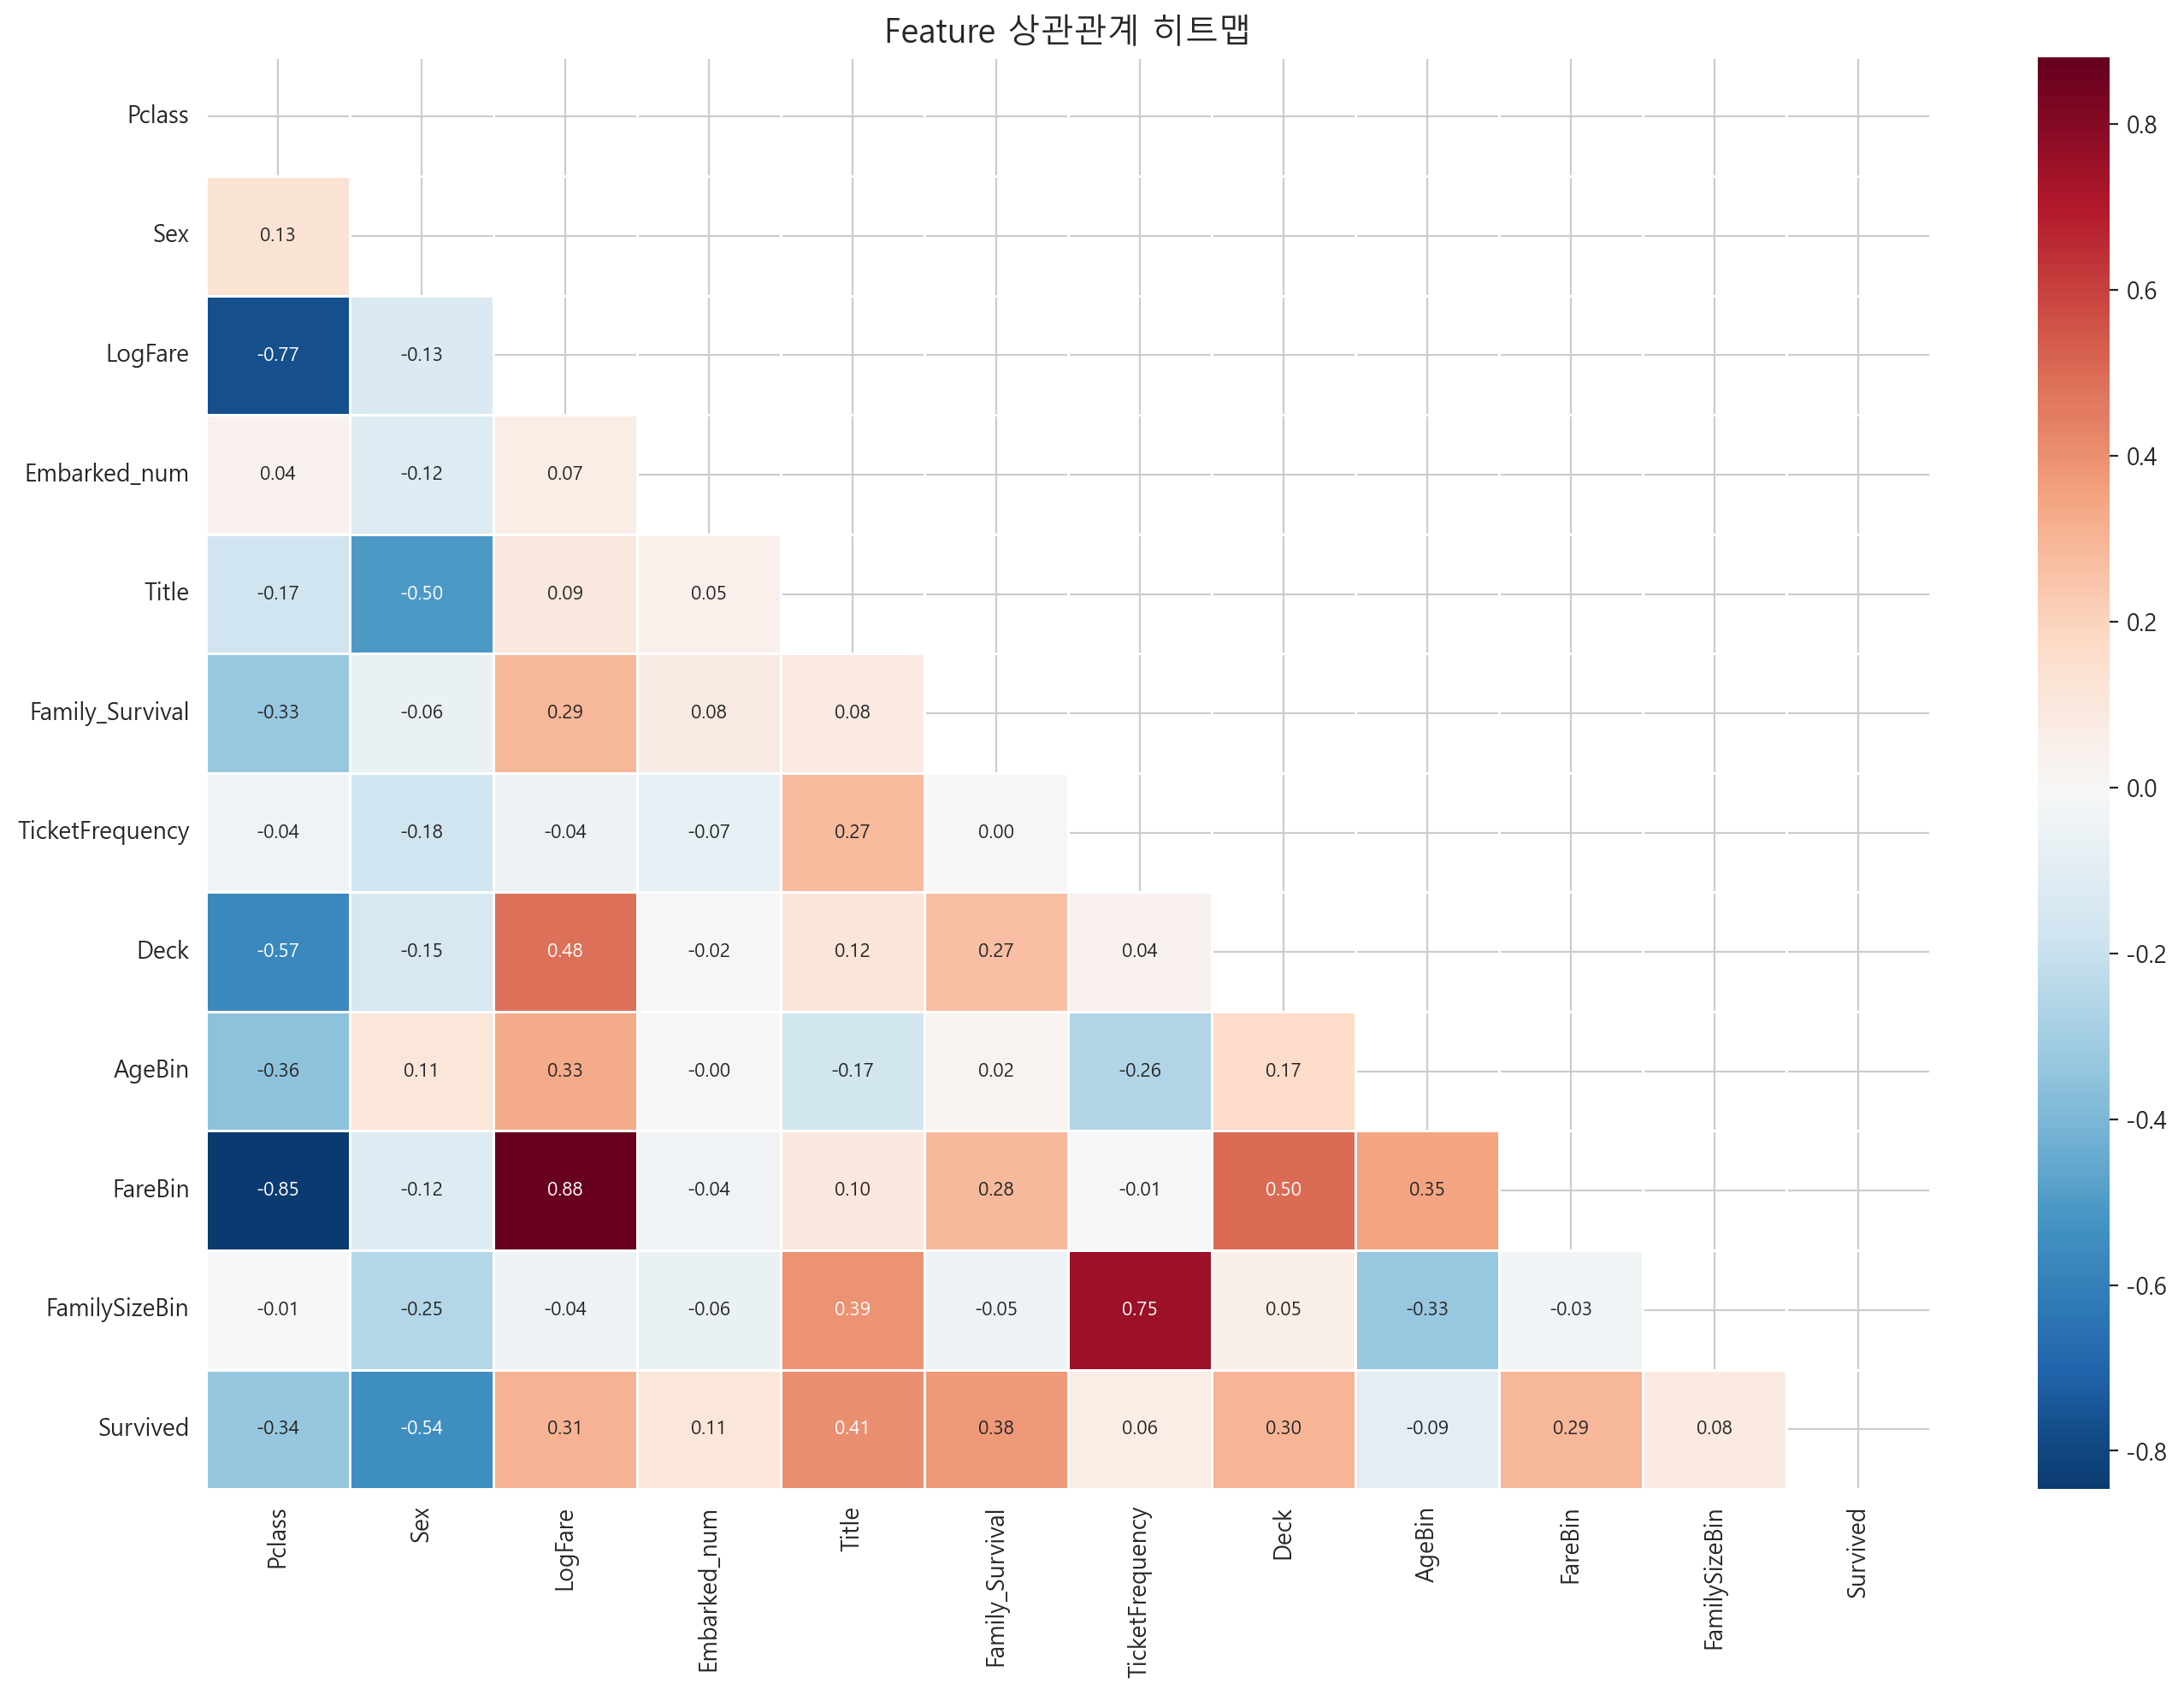

In [131]:
# ============================================================
# 7-3. 상관관계 히트맵
# ============================================================
plt.figure(figsize=(14, 10))
corr_matrix = train_processed[features + ['Survived']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, linewidths=0.5, annot_kws={'size': 8})
plt.title('Feature 상관관계 히트맵', fontsize=14)
plt.tight_layout()
plt.show()

In [132]:
# ============================================================
# 7-4. VIF Analysis (Variance Inflation Factor)
# ============================================================
print('📊 VIF Analysis (Variance Inflation Factor):')
print('=' * 50)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)
# Use X_initial instead of X_train (since we removed train/val split)
vif_df = calculate_vif(X_initial)
vif_df['Status'] = vif_df['VIF'].apply(
    lambda x: '🚨 주의' if x > 10 else ('⚠️ 경고' if x > 5 else '✅ 정상')
)
print(vif_df.to_string(index=False))

📊 VIF Analysis (Variance Inflation Factor):
        Feature       VIF Status
        LogFare 47.111163   🚨 주의
     Sex_Pclass 22.269269   🚨 주의
         Pclass 21.013479   🚨 주의
            Sex 19.802169   🚨 주의
        FareBin 12.504974   🚨 주의
         AgeBin  8.090845  ⚠️ 경고
TicketFrequency  5.388931  ⚠️ 경고
Family_Survival  4.013953   ✅ 정상
  FamilySizeBin  3.927166   ✅ 정상
          Title  2.200808   ✅ 정상
           Deck  1.845710   ✅ 정상
   Embarked_num  1.427737   ✅ 정상


📊 Feature Importance:
        Feature  Importance
          Title    0.254452
            Sex    0.239416
Family_Survival    0.132669
        LogFare    0.102260
TicketFrequency    0.062902
           Deck    0.058663
         Pclass    0.053841
         AgeBin    0.032773
        FareBin    0.032255
  FamilySizeBin    0.020802
   Embarked_num    0.009967


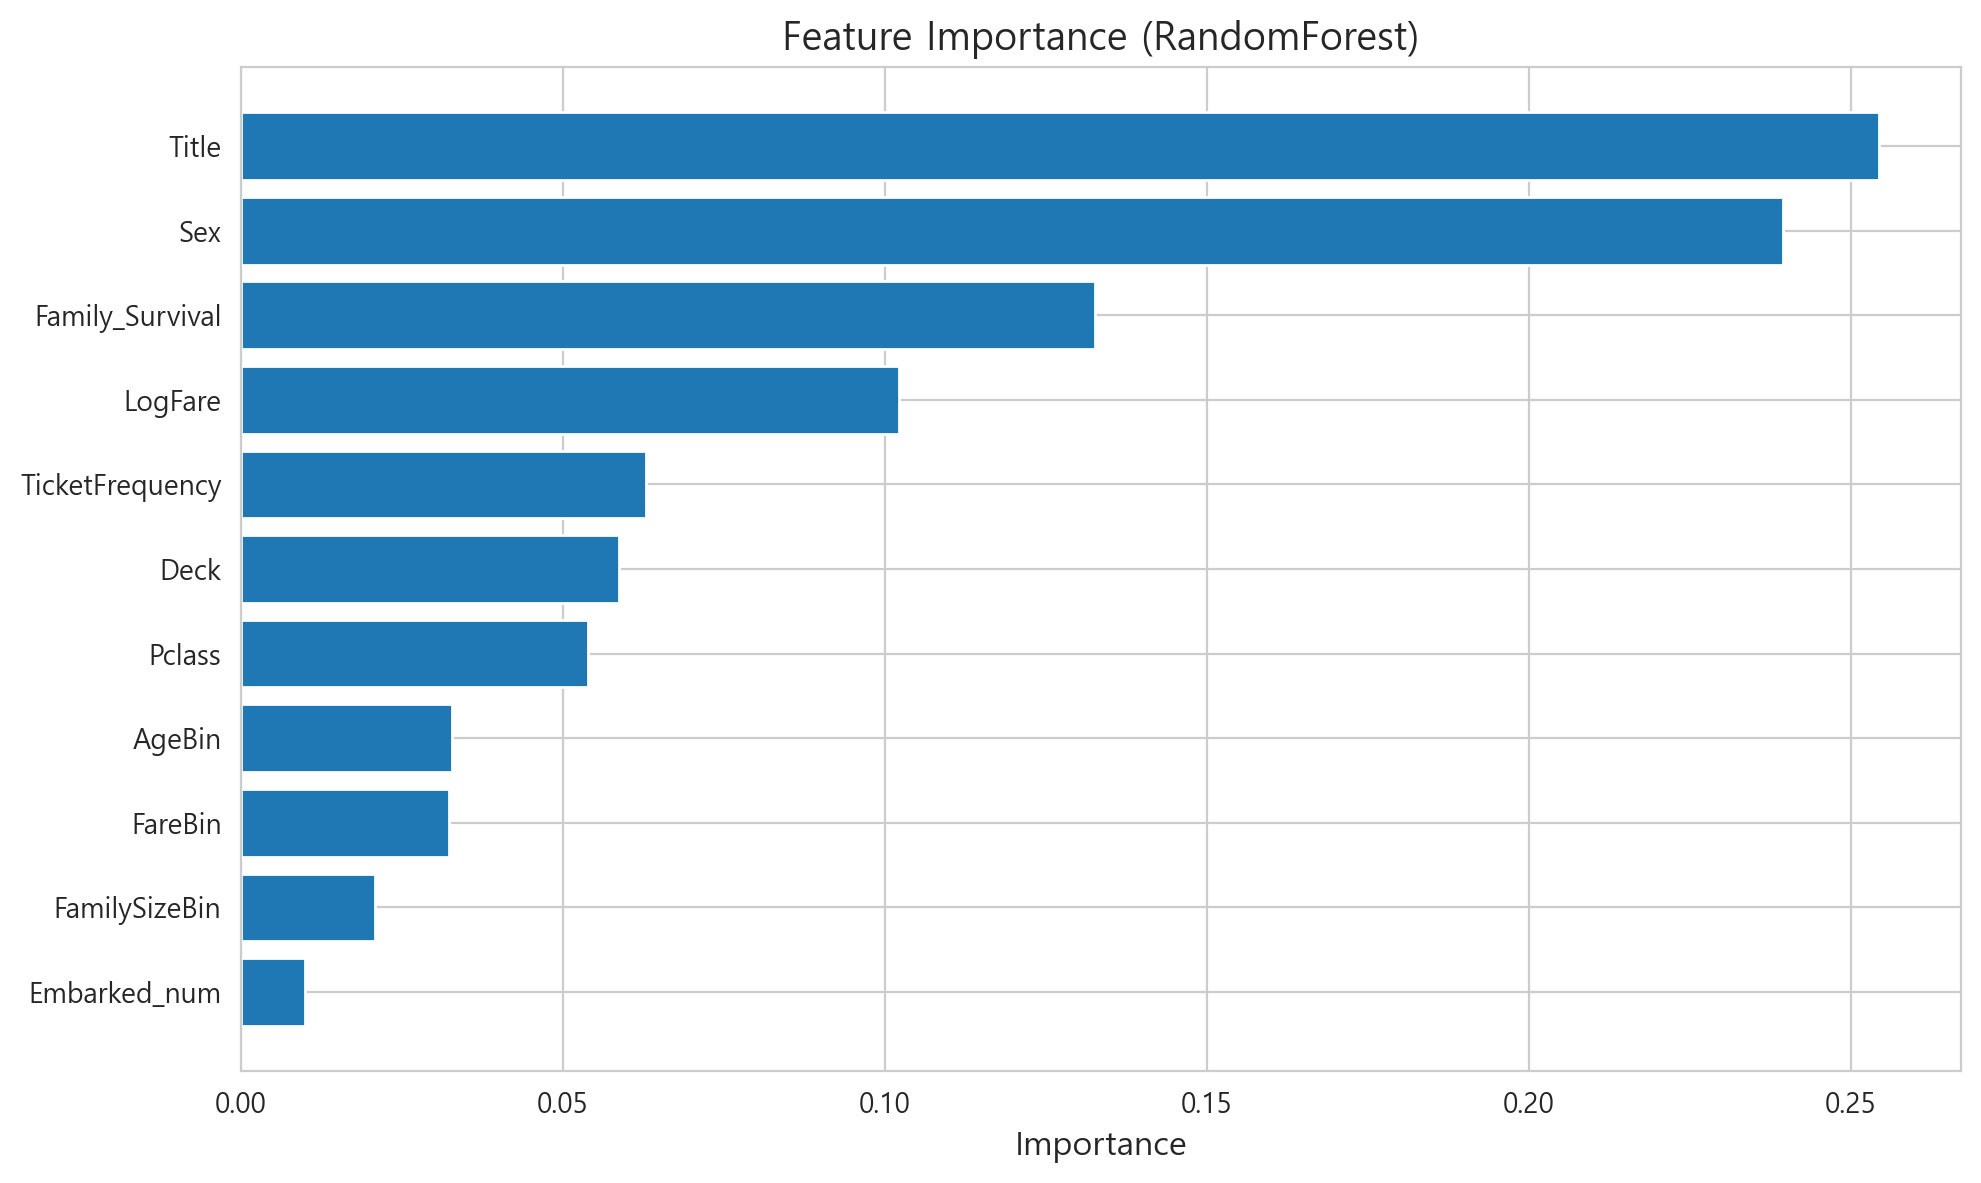

In [133]:
# ============================================================
# 7-5. Feature Importance
# ============================================================
# Train a simple RF for feature importance
rf_temp = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf_temp.fit(X, y)  # Changed from X_train, y_train
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,  # Changed from X_train.columns
    'Importance': rf_temp.feature_importances_
}).sort_values('Importance', ascending=False)
print('📊 Feature Importance:')
print(feature_importance.to_string(index=False))
# Optional: Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (RandomForest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [134]:
# ============================================================
# 8. 과적합 감지 함수
# ============================================================

def check_overfitting_with_feedback(model, X_data, y_data, model_name, cv, threshold=0.04):
    model_clone = clone(model)
    model_clone.fit(X_data, y_data)
    train_acc = model_clone.score(X_data, y_data)
    cv_scores = cross_val_score(model_clone, X_data, y_data, cv=cv, scoring='accuracy')
    cv_acc = cv_scores.mean()
    gap = train_acc - cv_acc
    is_overfitting = gap > threshold
    
    if gap > 0.10:
        print(f'🚨 {model_name}: 심각한 과적합! Train={train_acc:.4f}, CV={cv_acc:.4f}, Gap={gap:.4f}')
    elif gap > 0.05:
        print(f'⚠️ {model_name}: 과적합 경고. Train={train_acc:.4f}, CV={cv_acc:.4f}, Gap={gap:.4f}')
    else:
        print(f'✅ {model_name}: 정상. Train={train_acc:.4f}, CV={cv_acc:.4f}, Gap={gap:.4f}')
    
    return is_overfitting, gap, train_acc, cv_acc

print('✅ 과적합 감지 함수 정의 완료')

✅ 과적합 감지 함수 정의 완료


In [135]:
# ============================================================
# 9. AdaptiveHyperparams
# ============================================================

class AdaptiveHyperparams:
    def __init__(self):
        self.reset()
    def reset(self):
        self.max_depth_range = (2, 5)
        self.reg_alpha_min = 0.1
        self.reg_lambda_min = 0.1
        self.subsample_range = (0.6, 0.9)
        self.adjustment_count = 0
    def adjust_for_overfitting(self):
        self.adjustment_count += 1
        print(f'\n💊 과적합 조정 #{self.adjustment_count}')
        self.max_depth_range = (2, max(2, self.max_depth_range[1] - 2))
        self.reg_alpha_min = min(max(self.reg_alpha_min * 10, 1.0), 20.0)
        self.reg_lambda_min = min(max(self.reg_lambda_min * 10, 1.0), 20.0)
        self.subsample_range = (max(0.4, self.subsample_range[0] - 0.1), max(0.5, self.subsample_range[1] - 0.2))
        return self.adjustment_count < 3

adaptive_params = AdaptiveHyperparams()
print('✅ AdaptiveHyperparams 정의 완료')

✅ AdaptiveHyperparams 정의 완료


In [136]:
# ============================================================
# 10. Model Comparison (No Leak - Using Pipelines)
# ============================================================

# All models that need scaling use Pipeline
tree_models = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1),
    'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis()
}

# Scale-sensitive models MUST use Pipeline
scale_models = {
    'SVC': Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True, random_state=42))]),
    'KNeighbors': Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_jobs=-1))]),
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, random_state=42))]),
    'MLP': Pipeline([('scaler', StandardScaler()), ('model', MLPClassifier(max_iter=1000, random_state=42))])
}

all_models = {**tree_models, **scale_models}

print('📊 Model Comparison (No Leak):')
model_scores = {}
for name, model in all_models.items():
    try:
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        model_scores[name] = scores.mean()
        print(f'  {name}: {scores.mean():.4f} ± {scores.std():.4f}')
    except Exception as e:
        print(f'  {name}: Error - {e}')

sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
print(f'\\n🏆 Top 5:')
for name, score in sorted_models[:5]: print(f'  {name}: {score:.4f}')

📊 Model Comparison (No Leak):
  GradientBoosting: 0.8536 ± 0.0228
  RandomForest: 0.8327 ± 0.0210
  XGBoost: 0.8355 ± 0.0259
  ExtraTrees: 0.8200 ± 0.0267
  AdaBoost: 0.8340 ± 0.0242
  GaussianNB: 0.8008 ± 0.0282
  LDA: 0.8456 ± 0.0214
  SVC: 0.8504 ± 0.0234
  KNeighbors: 0.8352 ± 0.0203
  LogisticRegression: 0.8425 ± 0.0221
  MLP: 0.8389 ± 0.0218
\n🏆 Top 5:
  GradientBoosting: 0.8536
  SVC: 0.8504
  LDA: 0.8456
  LogisticRegression: 0.8425
  MLP: 0.8389


In [137]:
# ============================================================
# 11. Optuna XGBoost Tuning (No Leak)
# ============================================================

def tune_xgb(X_data, y_data, cv, cv_optuna, adaptive_params, max_iterations=3):
    adaptive_params.reset()
    for iteration in range(max_iterations):
        print(f'\\n{"="*50}\\n🚀 XGBoost 튜닝 #{iteration + 1}\\n{"="*50}')
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 250),
                'max_depth': trial.suggest_int('max_depth', adaptive_params.max_depth_range[0], adaptive_params.max_depth_range[1]),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
                'subsample': trial.suggest_float('subsample', adaptive_params.subsample_range[0], adaptive_params.subsample_range[1]),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
                'reg_alpha': trial.suggest_float('reg_alpha', adaptive_params.reg_alpha_min, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', adaptive_params.reg_lambda_min, 10.0, log=True),
                'random_state': 42, 'use_label_encoder': False, 'eval_metric': 'logloss', 'n_jobs': -1
            }
            return cross_val_score(XGBClassifier(**params), X_data, y_data, cv=cv_optuna, scoring='accuracy').mean()
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42+iteration))
        study.optimize(objective, n_trials=25, timeout=90, show_progress_bar=True)
        print(f'Best CV: {study.best_value:.4f}')
        best_model = XGBClassifier(**study.best_params, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
        best_model.fit(X_data, y_data)
        is_overfitting, _, _, _ = check_overfitting_with_feedback(best_model, X_data, y_data, 'XGBoost', cv)
        if not is_overfitting: return study, best_model
        if not adaptive_params.adjust_for_overfitting(): return study, best_model
    return study, best_model

study_xgb, best_xgb = tune_xgb(X, y, cv, cv_optuna, adaptive_params)

\n==================================================\n🚀 XGBoost 튜닝 #1\n==================================================


Best trial: 19. Best value: 0.861046: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it, 25.72/90 seconds]


Best CV: 0.8610
✅ XGBoost: 정상. Train=0.8754, CV=0.8585, Gap=0.0169


In [138]:
# ============================================================
# 12. Optuna RandomForest Tuning (No Leak)
# ============================================================

def tune_rf(X_data, y_data, cv, cv_optuna, adaptive_params, max_iterations=3):
    adaptive_params.reset()
    for iteration in range(max_iterations):
        print(f'\\n{"="*50}\\n🚀 RandomForest 튜닝 #{iteration + 1}\\n{"="*50}')
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 250),
                'max_depth': trial.suggest_int('max_depth', adaptive_params.max_depth_range[0], adaptive_params.max_depth_range[1] + 3),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
                'random_state': 42, 'n_jobs': -1
            }
            return cross_val_score(RandomForestClassifier(**params), X_data, y_data, cv=cv_optuna, scoring='accuracy').mean()
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42+iteration))
        study.optimize(objective, n_trials=25, timeout=90, show_progress_bar=True)
        print(f'Best CV: {study.best_value:.4f}')
        best_model = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
        best_model.fit(X_data, y_data)
        is_overfitting, _, _, _ = check_overfitting_with_feedback(best_model, X_data, y_data, 'RandomForest', cv)
        if not is_overfitting: return study, best_model
        if not adaptive_params.adjust_for_overfitting(): return study, best_model
    return study, best_model

study_rf, best_rf = tune_rf(X, y, cv, cv_optuna, adaptive_params)

\n==================================================\n🚀 RandomForest 튜닝 #1\n==================================================


Best trial: 12. Best value: 0.855217:  92%|█████████▏| 23/25 [01:33<00:08,  4.08s/it, 93.94/90 seconds]


Best CV: 0.8552
✅ RandomForest: 정상. Train=0.8653, CV=0.8543, Gap=0.0110


In [139]:
# ============================================================
# 13. Optuna GradientBoosting Tuning (No Leak)
# ============================================================

def tune_gb(X_data, y_data, cv, cv_optuna, adaptive_params, max_iterations=3):
    adaptive_params.reset()
    for iteration in range(max_iterations):
        print(f'\\n{"="*50}\\n🚀 GradientBoosting 튜닝 #{iteration + 1}\\n{"="*50}')
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 250),
                'max_depth': trial.suggest_int('max_depth', adaptive_params.max_depth_range[0], adaptive_params.max_depth_range[1]),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
                'subsample': trial.suggest_float('subsample', adaptive_params.subsample_range[0], adaptive_params.subsample_range[1]),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
                'random_state': 42
            }
            return cross_val_score(GradientBoostingClassifier(**params), X_data, y_data, cv=cv_optuna, scoring='accuracy').mean()
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42+iteration))
        study.optimize(objective, n_trials=25, timeout=90, show_progress_bar=True)
        print(f'Best CV: {study.best_value:.4f}')
        best_model = GradientBoostingClassifier(**study.best_params, random_state=42)
        best_model.fit(X_data, y_data)
        is_overfitting, _, _, _ = check_overfitting_with_feedback(best_model, X_data, y_data, 'GradientBoosting', cv)
        if not is_overfitting: return study, best_model
        if not adaptive_params.adjust_for_overfitting(): return study, best_model
    return study, best_model

study_gb, best_gb = tune_gb(X, y, cv, cv_optuna, adaptive_params)

\n==================================================\n🚀 GradientBoosting 튜닝 #1\n==================================================


Best trial: 22. Best value: 0.859926: 100%|██████████| 25/25 [01:14<00:00,  2.98s/it, 74.53/90 seconds]


Best CV: 0.8599
✅ GradientBoosting: 정상. Train=0.8878, CV=0.8559, Gap=0.0319


In [140]:
# ============================================================
# 13.5 Optuna SVC Tuning (Pipeline - No Leak)
# ============================================================

def tune_svc(X_data, y_data, cv, cv_optuna):
    print(f'\\n{"="*50}\\n🚀 SVC 튜닝 #1\\n{"="*50}')
    
    def objective(trial):
        params = {
            'C': trial.suggest_float('C', 0.1, 10.0, log=True),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
            'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly']),
            'probability': True,
            'random_state': 42
        }
        # Use Pipeline to prevent leak!
        pipe = Pipeline([('scaler', StandardScaler()), ('model', SVC(**params))])
        return cross_val_score(pipe, X_data, y_data, cv=cv_optuna, scoring='accuracy').mean()
    
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=25, timeout=90, show_progress_bar=True)
    print(f'Best CV: {study.best_value:.4f}')
    
    # Final model with Pipeline
    best_model = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', SVC(**study.best_params, probability=True, random_state=42))
    ])
    best_model.fit(X_data, y_data)
    
    cv_score = cross_val_score(best_model, X_data, y_data, cv=cv, scoring='accuracy').mean()
    print(f'✅ SVC Pipeline CV: {cv_score:.4f}')
    
    return study, best_model

study_svc, best_svc = tune_svc(X, y, cv, cv_optuna)

\n==================================================\n🚀 SVC 튜닝 #1\n==================================================


Best trial: 0. Best value: 0.853199: 100%|██████████| 25/25 [00:17<00:00,  1.47it/s, 17.04/90 seconds]


Best CV: 0.8532
✅ SVC Pipeline CV: 0.8505


In [141]:
# ============================================================
# 14. CV Performance
# ============================================================

tuned_models = {'XGBoost': best_xgb, 'RandomForest': best_rf, 'GradientBoosting': best_gb, 'SVC': best_svc}

print('📊 Final CV Performance:')
cv_results = {}
for name, model in tuned_models.items():
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_results[name] = cv_scores.mean()
    print(f'  {name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

📊 Final CV Performance:
  XGBoost: 0.8585 ± 0.0236
  RandomForest: 0.8543 ± 0.0221
  GradientBoosting: 0.8559 ± 0.0243
  SVC: 0.8505 ± 0.0232


In [142]:
# ============================================================
# 15. Ensemble (Improved)
# ============================================================
from sklearn.model_selection import cross_val_predict
# --- 1. OOF Stacking ---
oof_xgb = cross_val_predict(best_xgb, X, y, cv=5, method='predict_proba')[:, 1]
oof_rf = cross_val_predict(best_rf, X, y, cv=5, method='predict_proba')[:, 1]
oof_gb = cross_val_predict(best_gb, X, y, cv=5, method='predict_proba')[:, 1]
oof_svc = cross_val_predict(best_svc, X, y, cv=5, method='predict_proba')[:, 1]
X_meta = np.column_stack([oof_xgb, oof_rf, oof_gb, oof_svc])
meta_learner = LogisticRegression(C=0.1, max_iter=1000)
meta_cv = cross_val_score(meta_learner, X_meta, y, cv=5, scoring='accuracy').mean()
print(f'OOF Stacking CV: {meta_cv:.4f}')
# --- 2. Voting Ensembles ---
estimators = [
    ('XGBoost', best_xgb),
    ('RandomForest', best_rf),
    ('GradientBoosting', best_gb),
    ('SVC', best_svc)
]
voting_soft = VotingClassifier(estimators=estimators, voting='soft')
voting_soft.fit(X, y)
voting_soft_cv = cross_val_score(voting_soft, X, y, cv=cv, scoring='accuracy').mean()
print(f'Voting (Soft) CV: {voting_soft_cv:.4f}')
voting_hard = VotingClassifier(estimators=estimators, voting='hard')
voting_hard.fit(X, y)
voting_hard_cv = cross_val_score(voting_hard, X, y, cv=cv, scoring='accuracy').mean()
print(f'Voting (Hard) CV: {voting_hard_cv:.4f}')
# Weighted voting
weights = [cv_results['XGBoost'], cv_results['RandomForest'], 
           cv_results['GradientBoosting'], cv_results['SVC']]
voting_weighted = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
voting_weighted.fit(X, y)
weighted_cv = cross_val_score(voting_weighted, X, y, cv=cv, scoring='accuracy').mean()
print(f'Voting (Weighted) CV: {weighted_cv:.4f}')
# --- 3. Threshold Optimization ---
y_proba = cross_val_predict(voting_soft, X, y, cv=5, method='predict_proba')[:, 1]
best_threshold = 0.5
best_acc = 0
for threshold in np.arange(0.40, 0.60, 0.01):
    acc = accuracy_score(y, (y_proba >= threshold).astype(int))
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold
print(f'\\nOptimal threshold: {best_threshold:.2f}, Acc: {best_acc:.4f}')
print(f'\\n🏆 Best CV: {max(meta_cv, voting_soft_cv, voting_hard_cv, weighted_cv):.4f}')

OOF Stacking CV: 0.8541
Voting (Soft) CV: 0.8543
Voting (Hard) CV: 0.8538
Voting (Weighted) CV: 0.8544
\nOptimal threshold: 0.42, Acc: 0.8597
\n🏆 Best CV: 0.8544


In [ ]:
# ============================================================
# 16. 최종 제출
# ============================================================
import os
output_path = r'C:/Users/user/github/DataScience/scikit-learn/scikit-learn/Submission'
os.makedirs(output_path, exist_ok=True)
# Fit base models on full data for test predictions
best_xgb.fit(X, y)
best_rf.fit(X, y)
best_gb.fit(X, y)
best_svc.fit(X, y)
# OOF Stacking prediction
X_test_meta = np.column_stack([
    best_xgb.predict_proba(X_test)[:, 1],
    best_rf.predict_proba(X_test)[:, 1],
    best_gb.predict_proba(X_test)[:, 1],
    best_svc.predict_proba(X_test)[:, 1]
])
meta_learner.fit(X_meta, y)
# Save all submissions
for name, pred in [
    ('Pro6_OOF_Stacking', meta_learner.predict(X_test_meta)),
    ('Pro6_Voting_Soft', voting_soft.predict(X_test)),
    ('Pro6_Voting_Hard', voting_hard.predict(X_test)),
    ('Pro6_Voting_Weighted', voting_weighted.predict(X_test)),
    ('Pro6_Voting_Threshold', (voting_soft.predict_proba(X_test)[:, 1] >= best_threshold).astype(int))
]:
    pred = pred.astype(int)
    pd.DataFrame({'PassengerId': test_passenger_ids, 'Survived': pred}).to_csv(
        f'{output_path}/submission_{name}.csv', index=False)
    print(f'✅ submission_{name}.csv saved ({pred.sum()}/{len(pred)})')
print('\\n🎉 Complete!')

✅ submission_Pro6_OOF_Stacking.csv saved (152/418)
✅ submission_Pro6_Voting_Soft.csv saved (152/418)
✅ submission_Pro6_Voting_Hard.csv saved (145/418)
✅ submission_Pro6_Voting_Weighted.csv saved (152/418)
✅ submission_Pro6_Voting_Threshold.csv saved (159/418)
\n🎉 Complete!
